<a href="https://colab.research.google.com/github/joiortega1/Deep_Learning/blob/main/Proyecto/Proyecto_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Escuchando Emociones
- Ortega Ibarra Jaime Jesus

## Proyecto Final
### Deep Learning

# Introducción

Mediante el uso de Redes Neuronales Convolucionales se desea poder clasificar audios de acuerdo a la emoción que presenta el hablante de este.

Datos a utilzar:
- https://www.kaggle.com/uwrfkaggler/ravdess-emotional-speech-audio

## Preparación

In [2]:
! pip install torchinfo
try:
    import torchaudio
except:
    ! pip install torchaudio

     |████████████████████████████████| 1.9MB 8.0MB/s 


# Obtención de los datos

Es importante mencionar que el conujunto de datos será extraído desde el portal Kaggle, cuyo link es el siguiente:

- https://www.kaggle.com/uwrfkaggler/ravdess-emotional-speech-audio



Realizamos conexión con API de Kaggle, Dentro de Github he almacenado mis credenciales para poder utilizar dicha API, en el siguiente código extraemos esas credenciales y nos conectamos para descargar el conjunto de datos a utilizar.

In [3]:
!wget https://raw.githubusercontent.com/joiortega1/Deep_Learning/main/Proyecto/kaggle.json
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d uwrfkaggler/ravdess-emotional-speech-audio
!unzip 'ravdess-emotional-speech-audio.zip'

--2021-06-14 21:57:15--  https://raw.githubusercontent.com/joiortega1/Deep_Learning/main/Proyecto/kaggle.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 66 [text/plain]
Saving to: ‘kaggle.json’

kaggle.json         100%[===================>]      66  --.-KB/s    in 0s      

2021-06-14 21:57:15 (2.93 MB/s) - ‘kaggle.json’ saved [66/66]

 99% 426M/429M [00:04<00:00, 113MB/s]
100% 429M/429M [00:04<00:00, 92.9MB/s]
Archive:  ravdess-emotional-speech-audio.zip
  inflating: Actor_01/03-01-01-01-01-01-01.wav  
  inflating: Actor_01/03-01-01-01-01-02-01.wav  
  inflating: Actor_01/03-01-01-01-02-01-01.wav  
  inflating: Actor_01/03-01-01-01-02-02-01.wav  
  inflating: Actor_01/03-01-02-01-01-01-01.wav  
  inflating: Actor_01/03-01-02-01-01-02-01.wav  
  inflat

# Librerías

In [4]:
import pandas as pd
import random
import warnings
import librosa
import librosa.display
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
import glob
from sklearn.model_selection import train_test_split
import scipy.io.wavfile as waves
from scipy.io import wavfile
import IPython as ip
import soundfile as sf
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import torchaudio.transforms as T
import torchvision.models as tvm
from torch.utils.data import DataLoader
from torchaudio.datasets import SPEECHCOMMANDS
from torchinfo import summary
from torch.utils.data import Dataset
from torch.utils.data import Subset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from itertools import islice as take

### Auxiliares

In [5]:
warnings.simplefilter('ignore')
BATCH_SIZE = 32
SECS = 1
SAMPLE_RATE = 50000
ruta_carpet = "audio_speech_actors_01-24/"
def set_seed(seed=0):
  """Initializes pseudo-random number generators."""
  random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic = True
set_seed(seed=0)

# Datos
Contamos con 24 Actores, cada uno con 60 Audios correspondientes.

In [6]:
len(os.listdir('Actor_01'))

60

In [7]:
actores = [] # Creamos una lista vacía para almacenar el índice de nuestros actores
for i in range(1,25):
  if i < 10:
    path = 'Actor_0' + str(i)
    actores.append(path)
    print('Actor', i, ': ', len(os.listdir(path)),'Audios.')
  elif i > 9:
    path = 'Actor_' + str(i)
    actores.append(path)
    print('Actor', i, ':', len(os.listdir(path)),'Audios.')
len(actores)

Actor 1 :  60 Audios.
Actor 2 :  60 Audios.
Actor 3 :  60 Audios.
Actor 4 :  60 Audios.
Actor 5 :  60 Audios.
Actor 6 :  60 Audios.
Actor 7 :  60 Audios.
Actor 8 :  60 Audios.
Actor 9 :  60 Audios.
Actor 10 : 60 Audios.
Actor 11 : 60 Audios.
Actor 12 : 60 Audios.
Actor 13 : 60 Audios.
Actor 14 : 60 Audios.
Actor 15 : 60 Audios.
Actor 16 : 60 Audios.
Actor 17 : 60 Audios.
Actor 18 : 60 Audios.
Actor 19 : 60 Audios.
Actor 20 : 60 Audios.
Actor 21 : 60 Audios.
Actor 22 : 60 Audios.
Actor 23 : 60 Audios.
Actor 24 : 60 Audios.


24

# Mostrando un ejemplo de los audios

**03-01-04-02-01-01-22.wav**


- Modalidad: 03 (Solo Audio)
- Canal: 01 (Habla)
- Emoción: 04 (Triste)
- Intensidad: 02 (Fuerte)
- Discurso: 01 ("Kids are talking by the door")
- Repetición: 01 (1ra Repetición)
- Actor: 22


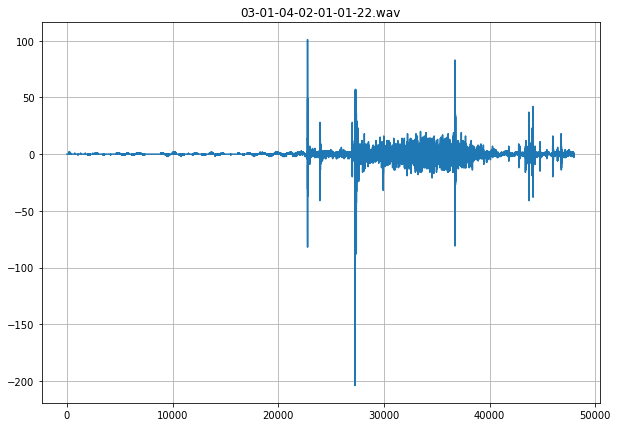

In [8]:
muestreo, sonido = waves.read('Actor_22/03-01-04-02-01-01-22.wav')
plt.figure(figsize=(10,7))
plt.title('03-01-04-02-01-01-22.wav')
plt.plot(sonido[0:muestreo]) 
plt.grid()
plt.show()
ip.display.Audio(sonido, rate=SAMPLE_RATE)

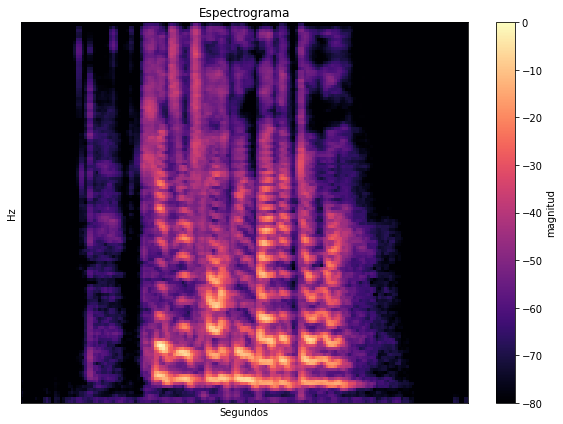

In [9]:
arreglo, sample = librosa.load('Actor_22/03-01-04-02-01-01-22.wav')
espectrograma = librosa.feature.melspectrogram(arreglo, sr=sample)
ls = librosa.power_to_db(espectrograma, ref=np.max)
plt.figure(figsize=(10,7))
librosa.display.specshow(ls, sr=sample)
plt.title('Espectrograma')
plt.xlabel('Segundos')
plt.ylabel('Hz')
cbar = plt.colorbar()
cbar.set_label('magnitud', rotation=90)
plt.show()

## Extrayendo características de los datos
Dado que nuestros audios contienen la información del conjunto dentro del nombre de estos, podemos extraer dicha información.

In [10]:
# Lista con nombre de atributos ordenados
atributos = ['Archivo', 'Modalidad', 'Canal', 'Emocion', 'Intensidad', 'Discurso', 'Repeticion', 'Actor']

# Diccionario Emoción-Etiqueta
emociones_dic = {1: 'neutral', 2: 'calma', 3: 'feliz', 4: 'triste', 5: 'enojado', 6: 'temeroso', 7: 'disgusto', 8: 'sorpresa'}

# Almacenando en una lista el nombre de todos los audios
audios = []
for actor in actores:
  audios.extend(os.listdir(actor))

print(f'Total: {len(audios)} audios.')

dir_list = os.listdir(ruta_carpet)
dir_list.sort()
path = []
emocion = []
for i in dir_list:
  for rn in os.listdir(ruta_carpet + i):
    emocion.append(int(rn.split('.')[0].split('-')[2]))
    path.append(ruta_carpet + i + '/' + rn)

Total: 1440 audios.


## Creando DataFrame a partir de los Datos

In [11]:
data = pd.DataFrame(columns = atributos)
data['Archivo'] = audios
# Llenando nuestro Data Frame con los valores del nombre del archivo
aux = 0
for name in audios:
  data.loc[aux, data.columns[1:]] = list(map(int, name.split('.')[0].split('-')))
  aux = aux + 1

# Añadiendo los segundos de cada uno de los audios
segundos = []
segundos_limpio = []
for i in range(len(data)):
  audio = data['Archivo'][i]
  ruta = 'Actor_' + str(data['Actor'][i]).zfill(2) + '/' + str(audio)
  y, sr = librosa.load(ruta)
  yt, index = librosa.effects.trim(y)

  # Utilizando effects.trim, podemos quitar silencios en nuestro audio.
  segundos.append(len(y)/sr)
  segundos_limpio.append(len(yt)/sr)

data['Path'] = path
data['Segundos'] = segundos
data['Segundos_Reales'] = segundos_limpio
emociones_df = pd.DataFrame(emocion)
emociones_df = emociones_df.replace({1: 'neutral', 2: 'calma', 3: 'feliz', 4: 'triste', 5: 'enojado', 6: 'temeroso', 7: 'disgusto', 8: 'sorpresa'})
emociones_df.columns = ['emocion']
data['Labels'] = emociones_df['emocion']
label_paht = data[['Labels','Path']]
data.head()

,Archivo,Modalidad,Canal,Emocion,Intensidad,Discurso,Repeticion,Actor,Path,Segundos,Segundos_Reales,Labels
0,03-01-03-01-01-02-01.wav,3,1,3,1,1,2,1,audio_speech_actors_01-24/Actor_01/03-01-03-01...,3.470159,2.066576,feliz
1,03-01-02-02-01-02-01.wav,3,1,2,2,1,2,1,audio_speech_actors_01-24/Actor_01/03-01-02-02...,4.004036,2.554195,calma
2,03-01-05-02-01-01-01.wav,3,1,5,2,1,1,1,audio_speech_actors_01-24/Actor_01/03-01-05-02...,4.104127,3.204354,enojado
3,03-01-05-01-02-01-01.wav,3,1,5,1,2,1,1,audio_speech_actors_01-24/Actor_01/03-01-05-01...,3.503537,1.927256,enojado
4,03-01-03-01-01-01-01.wav,3,1,3,1,1,1,1,audio_speech_actors_01-24/Actor_01/03-01-03-01...,3.470159,2.136236,feliz


In [12]:
data.head(10)

,Archivo,Modalidad,Canal,Emocion,Intensidad,Discurso,Repeticion,Actor,Path,Segundos,Segundos_Reales,Labels
0,03-01-03-01-01-02-01.wav,3,1,3,1,1,2,1,audio_speech_actors_01-24/Actor_01/03-01-03-01...,3.470159,2.066576,feliz
1,03-01-02-02-01-02-01.wav,3,1,2,2,1,2,1,audio_speech_actors_01-24/Actor_01/03-01-02-02...,4.004036,2.554195,calma
2,03-01-05-02-01-01-01.wav,3,1,5,2,1,1,1,audio_speech_actors_01-24/Actor_01/03-01-05-02...,4.104127,3.204354,enojado
3,03-01-05-01-02-01-01.wav,3,1,5,1,2,1,1,audio_speech_actors_01-24/Actor_01/03-01-05-01...,3.503537,1.927256,enojado
4,03-01-03-01-01-01-01.wav,3,1,3,1,1,1,1,audio_speech_actors_01-24/Actor_01/03-01-03-01...,3.470159,2.136236,feliz
5,03-01-06-01-02-02-01.wav,3,1,6,1,2,2,1,audio_speech_actors_01-24/Actor_01/03-01-06-01...,3.703719,2.554195,temeroso
6,03-01-07-02-02-01-01.wav,3,1,7,2,2,1,1,audio_speech_actors_01-24/Actor_01/03-01-07-02...,4.037415,2.832834,disgusto
7,03-01-06-02-01-02-01.wav,3,1,6,2,1,2,1,audio_speech_actors_01-24/Actor_01/03-01-06-02...,4.237596,4.051837,temeroso
8,03-01-04-01-01-01-01.wav,3,1,4,1,1,1,1,audio_speech_actors_01-24/Actor_01/03-01-04-01...,3.837188,2.809615,triste
9,03-01-07-01-01-01-01.wav,3,1,7,1,1,1,1,audio_speech_actors_01-24/Actor_01/03-01-07-01...,3.870522,3.181134,disgusto


Extrayendo nuestros datos objetivo para crear datos codificados

In [13]:
emocion_dummies = pd.DataFrame(0, index=data.index, columns=emociones_dic.values())
for i in range(len(emocion_dummies)):
  emocion_dummies.loc[i, emocion_dummies.columns[data.loc[i, 'Emocion']-1]]=1
emocion_dummies['Archivo'] = data['Archivo']
emocion_dummies.head()

,neutral,calma,feliz,triste,enojado,temeroso,disgusto,sorpresa,Archivo
0,0,0,1,0,0,0,0,0,03-01-03-01-01-02-01.wav
1,0,1,0,0,0,0,0,0,03-01-02-02-01-02-01.wav
2,0,0,0,0,1,0,0,0,03-01-05-02-01-01-01.wav
3,0,0,0,0,1,0,0,0,03-01-05-01-02-01-01.wav
4,0,0,1,0,0,0,0,0,03-01-03-01-01-01-01.wav


# Explorando nuestros Datos creados

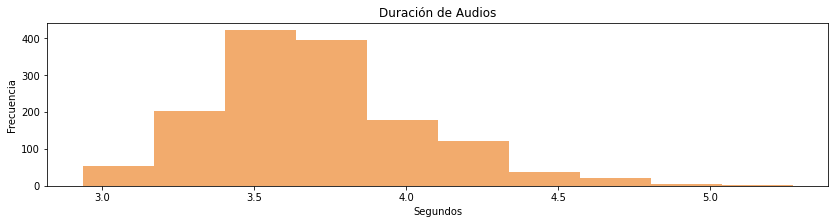

In [14]:
plt.figure(figsize=(14,3))
plt.hist(x=data['Segundos'].values, color='#F2AB6D', rwidth=1)
plt.title('Duración de Audios')
plt.xlabel('Segundos')
plt.ylabel('Frecuencia')
plt.show()

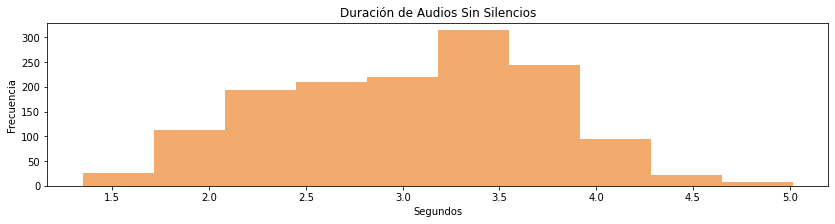

In [15]:
plt.figure(figsize=(14,3))
plt.hist(x=data['Segundos_Reales'].values, color='#F2AB6D', rwidth=1)
plt.title('Duración de Audios Sin Silencios')
plt.xlabel('Segundos')
plt.ylabel('Frecuencia')
plt.show()

Como podemos observar, encontramos diferentes duraciones en nuestros audios, esto se debe a espacios en silencio al inicio de nuestros audios

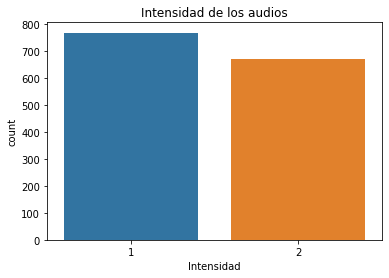

In [16]:
sns.countplot(data=data,x="Intensidad")
plt.title('Intensidad de los audios')
plt.show()

Como podemos observar, encontramos más audios cuya intensidad es Normal, que audios cuya intensidad es Fuerte

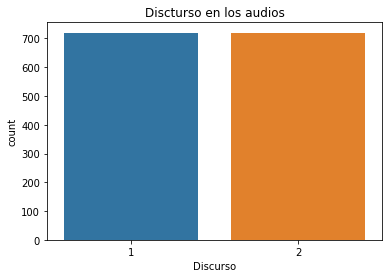

In [17]:
sns.countplot(data=data,x="Discurso")
plt.title('Discturso en los audios')
plt.show()

La cantidad de audios con cada frase es la misma.

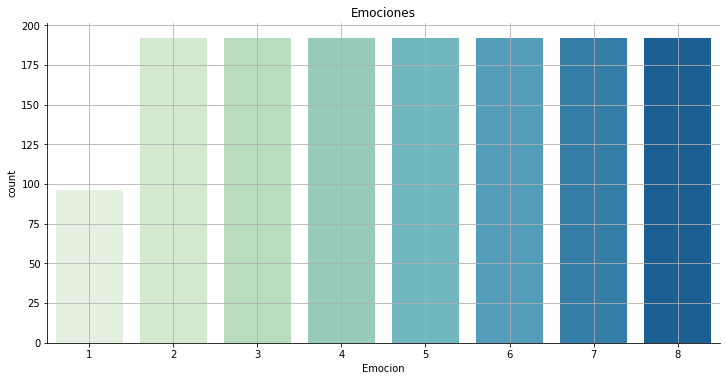

In [20]:
credit_t = sns.factorplot("Emocion", data=data, aspect=2, kind="count", palette="GnBu", margin_titles=True)
plt.title("Emociones")
plt.grid()
plt.show()

Encontramos menor cantidad de audios con emoción Neutral, en las demás encontramos la misma cantidad.

# Creando nuestro Dataloader y diviendo nuestros datos.

Es importante recalcar que se utilizarán 2 funciones importantes
- effects.trim()
- feature.mfcc()

La primera para eliminar el silencio en nuestros audios y la segunda para extraer los Coeficientes Cepstrales de Mel, los cuales nos ayudaran a tener un rango de características más amplio.

In [21]:
wav, sample = librosa.load('Actor_01/03-01-07-02-02-01-01.wav', sr=50000,duration=2,offset=0.75)

In [34]:
class create_dataset:

  def __init__(self, actores, data):
    self.samples = []
    # Extraemos el nombre de nuestros audios
    for actor in actores:
      for actor_wav in sorted(os.listdir(actor)):
        # Extraemos la etiqueta correspondiente, así como la intensidad
        etiqueta = actor_wav.split('.')[0].split('-')  
        intensidad = etiqueta[3]
        emocion = int(etiqueta[2])-1
        actor_id = etiqueta[6]
        # Guardamos la ruta de nuestro audio
        wav_path = os.path.join(actor, actor_wav)
        # Cargamos mediante librosa
        wav, sample = librosa.load(wav_path, sr=SAMPLE_RATE,duration=2,offset=0.75)
        # Con ayuda de effects.trim, eliminamos silencios
        #yt, index = librosa.effects.trim(wav)
        # Extraemos los coeficientes Cepstrales en la Escala de Mel
        #mfcc = librosa.feature.mfcc(y=yt, sr=sample, n_mfcc=32)
        # Almacenamos
        self.emociones_class = data['Emocion'].tolist()
        self.samples.append((torch.from_numpy(wav[np.newaxis,...]), emocion))

    #longitudes = [len(sample) for sample in wav
    #maxima_longitud = max(longitudes)
    #tensores = pad_sequence(samples, batch_first=True)
        
        
       

  def __getitem__(self, i):
    # Cargamos meta datos y guardamos valor de emoción
    return self.samples[i]

  def __len__(self):
    # Retornamos numero de ejemplos
    return len(self.samples)

new_data = create_dataset(actores, data)

In [35]:
new_data[0]

(tensor([[-1.8569e-06,  4.8537e-07,  2.8870e-05,  ...,  6.3156e-07,
          -7.5399e-07,  7.8539e-07]]), 0)

In [36]:
def build_dl(dataframe, BATCH_SIZE=32, shuffle=False):
    dl = DataLoader(
        dataframe,
        batch_size=BATCH_SIZE,
        shuffle=shuffle,
    )
    return dl

In [37]:
X_Train, val_train = train_test_split(list(range(len(new_data))), test_size=0.15+0.10, random_state=42)
df = {}
X_Test = val_train[:int((0.10/(0.15+0.10))*len(val_train))]
val_train = val_train[int((0.10/(0.15+0.10))*len(val_train)):]
df['Data_Test'] = Subset(new_data, X_Test)
df['Data_Train'] = Subset(new_data, X_Train)
df['Data_Val'] = Subset(new_data, val_train)

val_dl = build_dl(df['Data_Val'])
tst_dl = build_dl(df['Data_Test'])
trn_dl = build_dl(df['Data_Train'])

x shape=torch.Size([32, 1, 100000]) dtype=torch.float32
y shape=torch.Size([32]) dtype=torch.int64


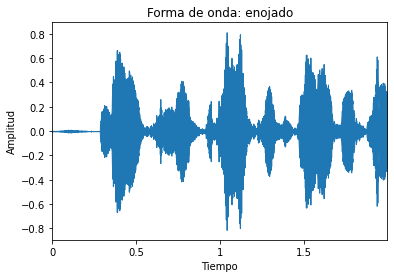

In [38]:
# desplegamos un lote de audios
x, y = next(iter(val_dl))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')

# inspeccionemos un ejemplo
waveform = x[0].squeeze().numpy()
label = emociones_dic[(y[0]+1).item()]

# grafiquemos forma de onda
librosa.display.waveplot(waveform, sr=SAMPLE_RATE)
plt.title(f'Forma de onda: {label}')
plt.xlabel('Tiempo')
plt.ylabel('Amplitud')
plt.show()

# reproductor
ip.display.Audio(waveform, rate=SAMPLE_RATE)

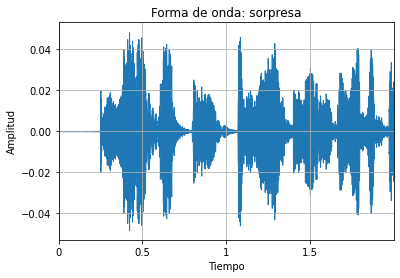

In [39]:
trn_dl = build_dl(df['Data_Train'])

# desplegamos un lote de audios
x, y = next(iter(trn_dl))

# inspeccionemos un ejemplo
waveform = x[0].squeeze().numpy()
label = emociones_dic[(y[0]+1).item()]

# grafiquemos forma de onda
librosa.display.waveplot(waveform, sr=SAMPLE_RATE)
plt.title(f'Forma de onda: {label}')
plt.xlabel('Tiempo')
plt.ylabel('Amplitud')
plt.grid()
plt.show()

# reproductor
ip.display.Audio(waveform, rate=SAMPLE_RATE)

In [40]:
def train_epoch(dl, model, opt, device):

    # por cada lote
    for x, y_true, *_ in dl:

        # movemos a dispositivo
        x = x.to(device)
        y_true = y_true.to(device)

        # computamos logits
        y_lgts = model(x)

        # computamos la pérdida
        loss = F.cross_entropy(y_lgts, y_true)

        # vaciamos los gradientes
        opt.zero_grad()

        # retropropagamos
        loss.backward()

        # actualizamos parámetros
        opt.step()


def eval_epoch(dl, model, device, num_batches=None):

    # evitamos que se registren las operaciones 
    # en la gráfica de cómputo
    with torch.no_grad():

        # historiales
        losses, accs = [], []

        # validación de la época con num_batches
        # si num_batches==None, se usan todos los lotes
        for x, y_true, *_ in take(dl, num_batches):

            # movemos a dispositivo
            x = x.to(device)
            y_true = y_true.to(device)

            # computamos los logits
            y_lgts = model(x)

            # computamos los puntajes
            y_prob = F.softmax(y_lgts, 1)

            # computamos la clases
            y_pred = torch.argmax(y_prob, 1)

            # computamos la pérdida
            loss = F.cross_entropy(y_lgts, y_true)

            # computamos la exactitud
            acc = (y_true == y_pred).type(torch.float32).mean()

            # guardamos históricos
            losses.append(loss.item())
            accs.append(acc.item())

        # promediamos
        loss = np.mean(losses) * 100
        acc = np.mean(accs) * 100

        return loss, acc
        
        
def train(model, trn_dl, tst_dl, lr=1e-4, epochs=20,
          trn_batches=None, tst_batches=None):

    # historiales
    loss_hist, acc_hist = [], []
    
    # optimizador
    opt = optim.Adam(model.parameters(), lr=lr)

    # usamos GPU si está disponible
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # movemos a dispositivo
    model.to(device)

    # ciclo de entrenamiento
    for epoch in range(epochs):

        # modelo en modo de entrenamiento
        model.train()
        # entrenamos la época
        train_epoch(trn_dl, model, opt, device)

        # modelo en modo de evaluación
        model.eval()
        # evaluamos la época en entrenamiento
        trn_loss, trn_acc = eval_epoch(trn_dl, model, device, trn_batches)
        # evaluamos la época en prueba
        tst_loss, tst_acc = eval_epoch(tst_dl, model, device, tst_batches)

        # guardamos historial
        loss_hist.append([trn_loss, tst_loss])
        acc_hist.append([trn_acc, tst_acc])

        # imprimimos progreso
        print(f'E{epoch:02} '
              f'loss=[{trn_loss:6.2f},{tst_loss:6.2f}] '
              f'acc=[{trn_acc:5.2f},{tst_acc:5.2f}]')

    return loss_hist, acc_hist


# Arquitectura M5

In [41]:
class M5B2(nn.Module):

    def __init__(self, n_in_channels=1, n_classes=8, 
                 stride=16, n_channel=64):
        super().__init__()

        self.cnn = nn.Sequential(

            # bloque conv 1
            nn.Conv1d(in_channels=n_in_channels, 
                      out_channels=n_channel, 
                      kernel_size=80, stride=stride),
            nn.BatchNorm1d(num_features=n_channel),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=4, stride=4),

            # bloque conv 2
            nn.Conv1d(in_channels=n_channel, 
                      out_channels=n_channel, 
                      kernel_size=3),
            nn.BatchNorm1d(num_features=n_channel),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=4, stride=4),

        )

        self.pool = nn.AdaptiveAvgPool1d(1)
        self.flat = nn.Flatten()
        self.fc = nn.Linear(n_channel, n_classes)


    def forward(self, x):
        x = self.cnn(x)
        x = self.pool(x)
        x = self.flat(x)
        x = self.fc(x)
        return x


def build_m5b2():
    return M5B2()

m5b2 = build_m5b2()
m5b2

M5B2(
  (cnn): Sequential(
    (0): Conv1d(1, 64, kernel_size=(80,), stride=(16,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (pool): AdaptiveAvgPool1d(output_size=1)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=64, out_features=8, bias=True)
)

In [42]:
x = torch.zeros(1, 1, 16000)
y = m5b2(x)
print(f'{x.shape} => {y.shape}')

torch.Size([1, 1, 16000]) => torch.Size([1, 8])


In [43]:
summary(m5b2, (1, 1, 16000), device='cpu', verbose=0,
        col_names=['input_size', 'output_size', 'num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
M5B2                                     --                        --                        --
├─Sequential: 1-1                        [1, 1, 16000]             [1, 64, 61]               --
│    └─Conv1d: 2-1                       [1, 1, 16000]             [1, 64, 996]              5,184
│    └─BatchNorm1d: 2-2                  [1, 64, 996]              [1, 64, 996]              128
│    └─ReLU: 2-3                         [1, 64, 996]              [1, 64, 996]              --
│    └─MaxPool1d: 2-4                    [1, 64, 996]              [1, 64, 249]              --
│    └─Conv1d: 2-5                       [1, 64, 249]              [1, 64, 247]              12,352
│    └─BatchNorm1d: 2-6                  [1, 64, 247]              [1, 64, 247]              128
│    └─ReLU: 2-7                         [1, 64, 247]              [1, 64, 247]              --
│    └─MaxPool1d: 2-8     

In [44]:
model = build_m5b2()

In [45]:
set_seed()
loss_hist, acc_hist = train(model,trn_dl,val_dl, lr=1e-4, epochs=300)

E00 loss=[209.05,205.75] acc=[13.11,17.56]
E01 loss=[199.17,194.02] acc=[18.66,19.79]
E02 loss=[191.30,185.20] acc=[22.15,25.74]
E03 loss=[189.43,183.38] acc=[23.99,26.04]
E04 loss=[188.26,182.22] acc=[28.55,30.65]
E05 loss=[187.13,181.06] acc=[29.35,36.31]
E06 loss=[186.21,180.04] acc=[30.42,37.05]
E07 loss=[185.56,179.34] acc=[30.24,34.82]
E08 loss=[184.89,178.69] acc=[30.91,35.71]
E09 loss=[184.29,178.06] acc=[31.46,36.16]
E10 loss=[183.71,177.47] acc=[31.65,36.01]
E11 loss=[183.20,176.96] acc=[31.71,36.61]
E12 loss=[182.65,176.45] acc=[32.35,36.01]
E13 loss=[182.16,175.96] acc=[32.35,38.10]
E14 loss=[181.73,175.53] acc=[33.36,35.71]
E15 loss=[181.30,175.12] acc=[33.18,36.31]
E16 loss=[180.89,174.67] acc=[33.27,36.31]
E17 loss=[180.47,174.17] acc=[33.55,37.05]
E18 loss=[180.11,173.87] acc=[34.01,36.90]
E19 loss=[179.79,173.52] acc=[33.73,34.82]
E20 loss=[179.47,173.14] acc=[33.46,35.27]
E21 loss=[179.16,172.78] acc=[33.73,35.71]
E22 loss=[178.83,172.44] acc=[34.38,35.27]
E23 loss=[1

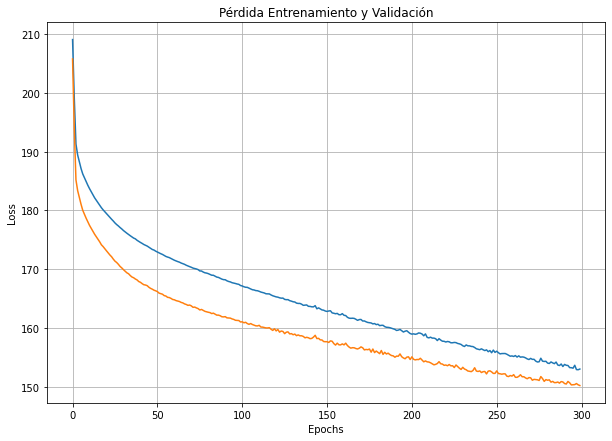

In [46]:
plt.figure(figsize=(10,7))
plt.title('Pérdida Entrenamiento y Validación')
plt.plot(loss_hist)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.show()

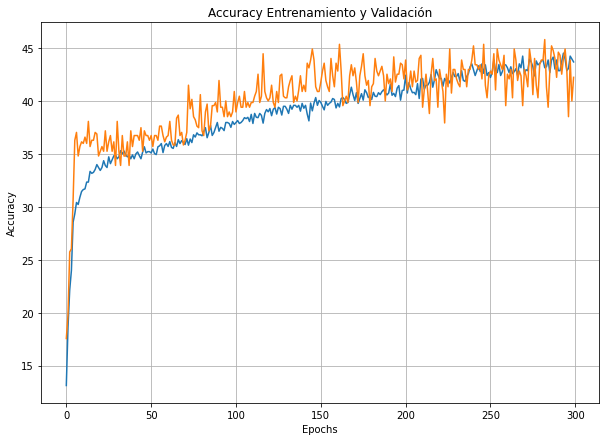

In [47]:
plt.figure(figsize=(10,7))
plt.title('Accuracy Entrenamiento y Validación')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(acc_hist)
plt.grid()
plt.show()

In [53]:
images, labels = next(iter(tst_dl))
salida = model(images.cuda())
x, pred = torch.max(salida, 1)
emociones = ('neutral', 'calma', 'feliz', 'triste', 'enojado', 'temeroso', 'disgusto', 'sorprendido')

# Predicciones

In [54]:
waveform = images[1].squeeze().numpy()
print('\nEtiqueta Real: ', emociones[labels[1]])
print('Predicción: ',emociones[pred[1]])
ip.display.Audio(waveform, rate=SAMPLE_RATE)


Etiqueta Real:  calma
Predicción:  calma


In [55]:
waveform = images[15].squeeze().numpy()
print('\nEtiqueta Real: ', emociones[labels[15]])
print('Predicción: ',emociones[pred[15]])
ip.display.Audio(waveform, rate=SAMPLE_RATE)


Etiqueta Real:  disgusto
Predicción:  triste


In [56]:
waveform = images[28].squeeze().numpy()
print('\nEtiqueta Real: ', emociones[labels[28]])
print('Predicción: ',emociones[pred[28]])
ip.display.Audio(waveform, rate=SAMPLE_RATE)


Etiqueta Real:  disgusto
Predicción:  disgusto


In [57]:
waveform = images[7].squeeze().numpy()
print('\nEtiqueta Real: ', emociones[labels[7]])
print('Predicción: ',emociones[pred[7]])
ip.display.Audio(waveform, rate=SAMPLE_RATE)


Etiqueta Real:  temeroso
Predicción:  temeroso


In [59]:
waveform = images[31].squeeze().numpy()
print('\nEtiqueta Real: ', emociones[labels[31]])
print('Predicción: ',emociones[pred[31]])
ip.display.Audio(waveform, rate=SAMPLE_RATE)


Etiqueta Real:  enojado
Predicción:  enojado


In [68]:
waveform = images[21].squeeze().numpy()
print('\nEtiqueta Real: ', emociones[labels[21]])
print('Predicción: ',emociones[pred[21]])
ip.display.Audio(waveform, rate=SAMPLE_RATE)


Etiqueta Real:  neutral
Predicción:  calma
